<a href="https://colab.research.google.com/github/marcusnk237/ECG-Classification-COVID/blob/main/ECG_COVID_Classification_2CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import glob
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import csv
import itertools
from imblearn.over_sampling import SMOTE
from collections import Counter
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import seaborn as sn
%matplotlib inline
%pylab inline
%config InlineBackend.figure_formats = ['retina']
from imutils import paths
import time
import cv2
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.preprocessing import image
from sklearn.utils import shuffle
from tqdm import tqdm
from collections import Counter
import os.path, sys, re
import time
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


In [5]:
!pip install -U -q kaggle==1.5.8
########################

### Select kaggle.json file ##
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marcjuniornkengue","key":"58445b157d5149ac1ddb370e10df9c47"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [7]:
!kaggle datasets download -d marcjuniornkengue/ecg-image-cropped

 99% 1.30G/1.31G [00:08<00:00, 196MB/s]
100% 1.31G/1.31G [00:08<00:00, 164MB/s]


In [8]:
!unzip \*.zip  && rm *.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead2.png  
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead3.png  
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead4.png  
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead5.png  
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead6.png  
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead7.png  
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead8.png  
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead9.png  
  inflating: ECG/Normal/Cropped_Images/Normal_166Cropped_lead1.png  
  inflating: ECG/Normal/Cropped_Images/Normal_166Cropped_lead10.png  
  inflating: ECG/Normal/Cropped_Images/Normal_166Cropped_lead11.png  
  inflating: ECG/Normal/Cropped_Images/Normal_166Cropped_lead12.png  
  inflating: ECG/Normal/Cropped_Images/Normal_166Cropped_lead13.png  
  inflating: ECG/Norm

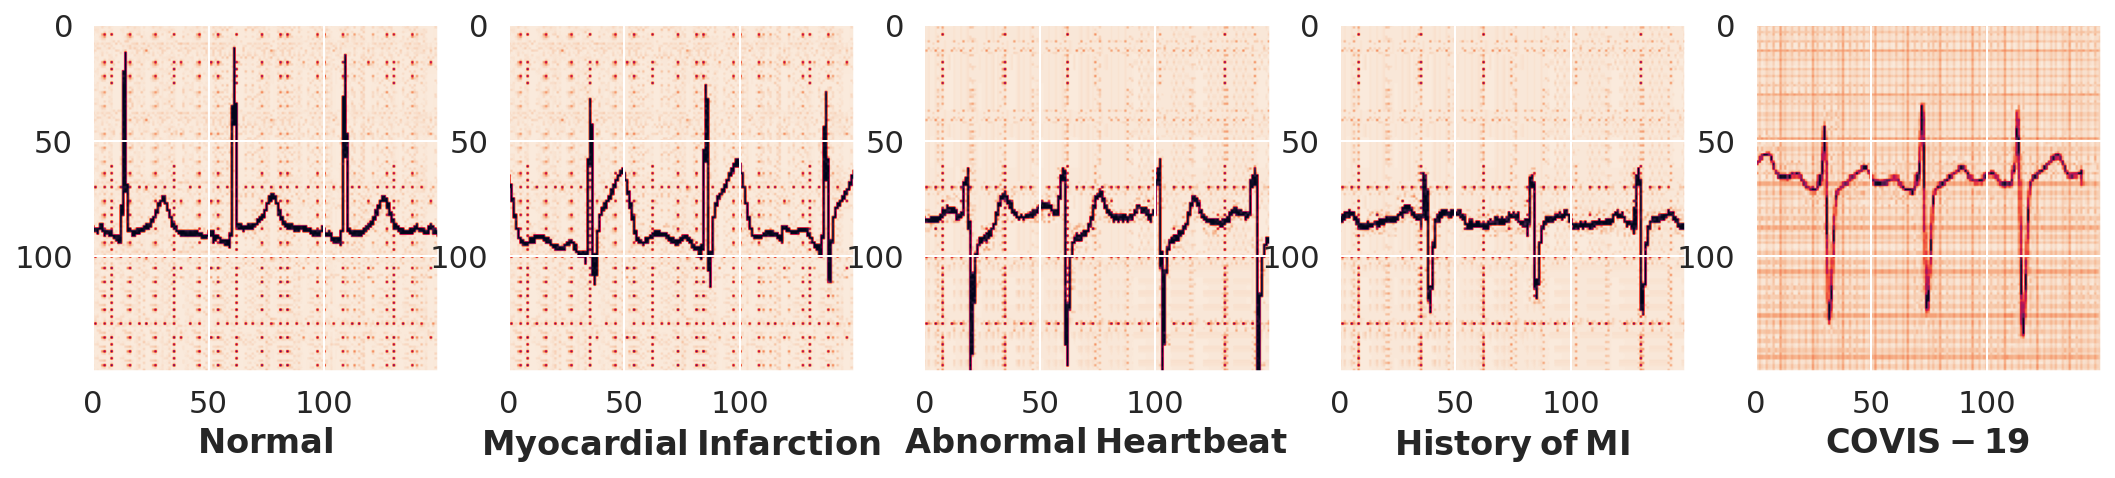

In [33]:
fig, (ax1, ax2, ax3, ax4,ax5) = plt.subplots(1, 5, figsize=(18, 5))
img0 = image.load_img('/content/ECG/Normal/Cropped_Images/Normal_100Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
ax1.imshow(img0)
ax1.set_xlabel(r"$\bf{Normal}$")
img1 = image.load_img('/content/ECG/MI/Cropped_Images/MI_20Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
ax2.imshow(img1)
ax2.set_xlabel(r"$\bf{Myocardial\: Infarction}$")
img2 = image.load_img('/content/ECG/HB/Cropped_Images/HB_20Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
ax3.imshow(img2)
ax3.set_xlabel(r"$\bf{Abnormal\:  Heartbeat}$")
img3 = image.load_img('/content/ECG/PMI/Cropped_Images/PMI_20Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
ax4.imshow(img3)
ax4.set_xlabel(r"$\bf{History\:  of\:  MI}$")
img4 = image.load_img('/content/ECG/COVID/Cropped_Images/Binder1_Page_001Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
ax5.imshow(img4)
ax5.set_xlabel(r"$\bf{COVIS-19}$")

fig.savefig("representative_ECG_images.png",dpi=300)

In [34]:
images = []
labels = []

dirs = ['Normal','HB','PMI', 'MI','COVID']

for dir in dirs:
  print(dir)
  for filename in os.listdir('/content/ECG/{}/Cropped_Images/'.format(dir)):
    if filename.endswith("png") and "lead4" in filename: 
      images.append('/content/ECG/{}/Cropped_Images/{}'.format(dir,filename))
      labels.append(dirs.index(dir))

df = pd.DataFrame({"image":images, "label":labels})
df.to_csv("ECG_covid_set.csv", index=False)

Normal
HB
PMI
MI
COVID


In [35]:
imagedata = []
for i in tqdm(range(df.shape[0])):
    img = image.load_img('{}'.format(df["image"][i]), target_size=(150,150,1), grayscale=True) #, grayscale=True
    img = image.img_to_array(img)
    img = img/255
    imagedata.append(img)
X = np.array(imagedata)

100%|██████████| 1178/1178 [00:02<00:00, 506.57it/s]


In [36]:
y=df['label'].values
y = to_categorical(y) #one-hot encoding

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.2, shuffle=True, stratify=y)

In [38]:
model = models.Sequential()
model.add(layers.Conv2D(128, kernel_size=(3, 3),activation='relu',input_shape=(150,150,1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 128)     1280      
                                                                 
 conv2d_5 (Conv2D)           (None, 146, 146, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 71, 71, 32)        18464     
                                                                 
 conv2d_7 (Conv2D)           (None, 69, 69, 32)        9248      
                                                                 
 flatten_1 (Flatten)         (None, 152352)            0         
                                                      

In [40]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

In [41]:
history=model.fit(X_train, y_train, epochs=17, validation_data=(X_test, y_test))

Epoch 1/17
30/30 [==============================] - 4s 112ms/step - loss: 1.6357 - accuracy: 0.2261 - val_loss: 1.5048 - val_accuracy: 0.3008
Epoch 2/17
30/30 [==============================] - 3s 104ms/step - loss: 1.0819 - accuracy: 0.5573 - val_loss: 0.6778 - val_accuracy: 0.7034
Epoch 3/17
30/30 [==============================] - 3s 103ms/step - loss: 0.3957 - accuracy: 0.8673 - val_loss: 0.5917 - val_accuracy: 0.8008
Epoch 4/17
30/30 [==============================] - 3s 103ms/step - loss: 0.1603 - accuracy: 0.9448 - val_loss: 0.5052 - val_accuracy: 0.8729
Epoch 5/17
30/30 [==============================] - 3s 103ms/step - loss: 0.0495 - accuracy: 0.9820 - val_loss: 0.4926 - val_accuracy: 0.9068
Epoch 6/17
30/30 [==============================] - 3s 104ms/step - loss: 0.0101 - accuracy: 0.9979 - val_loss: 0.5918 - val_accuracy: 0.9025
Epoch 7/17
30/30 [==============================] - 3s 104ms/step - loss: 0.0086 - accuracy: 0.9968 - val_loss: 0.6960 - val_accuracy: 0.8941
Epoch 

In [42]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9996757507324219
Test accuracy: 0.8813559412956238


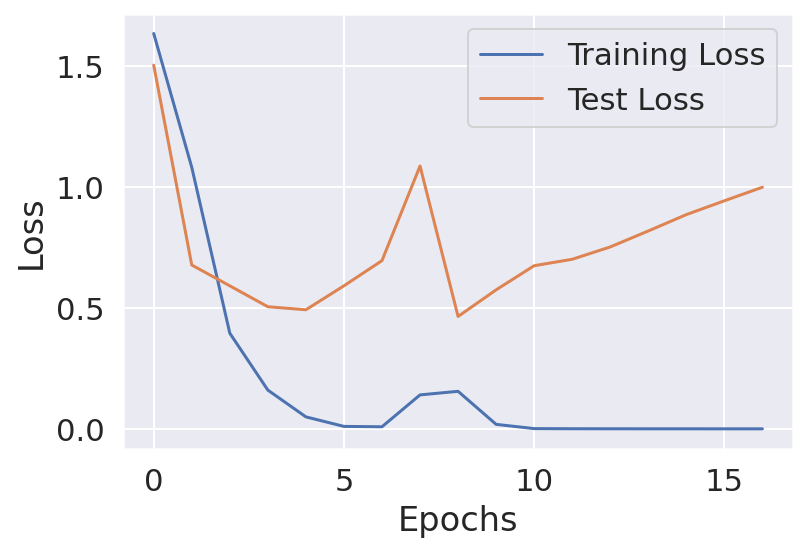

In [44]:
plt.plot(history.history['loss'],label="Training Loss")
plt.plot(history.history['val_loss'],label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss_2DCNN.png", dpi=300, bbox_inches="tight")

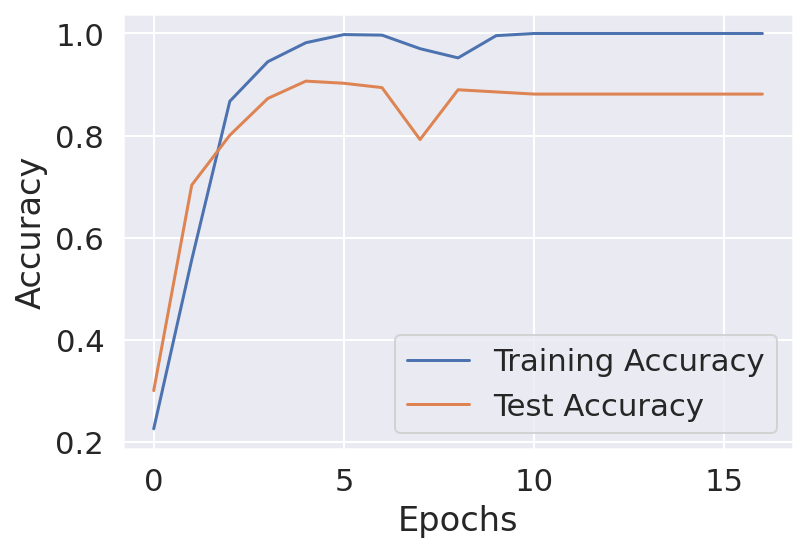

In [45]:
plt.plot(history.history['accuracy'],label="Training Accuracy")
plt.plot(history.history['val_accuracy'],label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("Accuracy_2DCNN.png", dpi=300, bbox_inches="tight")

In [46]:
import sklearn.metrics as metrics

y_test_pred = model.predict(X_test)  
y_test_pred_labels = np.argmax(y_test_pred, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
# print(y_test_pred_labels)
y_test_labels = np.argmax(y_test, axis=1)
# print(y_test_labels)
confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=y_test_pred_labels) 

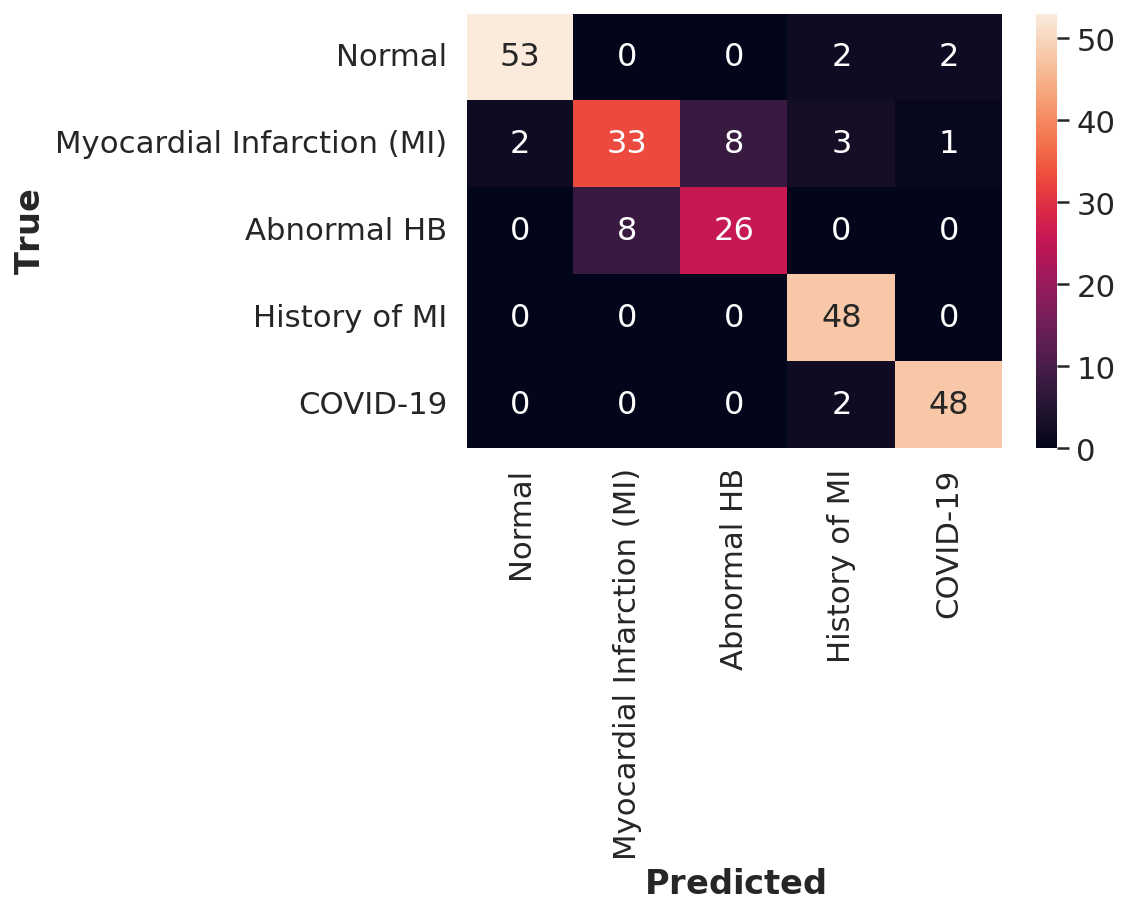

In [47]:
x_axis_labels = ["Normal", "Myocardial Infarction (MI)", "Abnormal HB", "History of MI", "COVID-19"]
y_axis_labels = ["Normal", "Myocardial Infarction (MI)", "Abnormal HB", "History of MI","COVID-19"]

df_cm = pd.DataFrame(confusion_matrix, range(5), range(5))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g',xticklabels=x_axis_labels, yticklabels=y_axis_labels) # font size

plt.xlabel(r"$\bf{Predicted}$")
plt.ylabel(r"$\bf{True}$")

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# red_patch = mpatches.Patch(color=None, label='The red data')
# blue_patch = mpatches.Patch(color='blue', label='The blue data')

# plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.25, 1), loc='upper left')
# plt.tight_layout()
plt.savefig("Confusion_matrix_2DCNN.png", dpi=300, bbox_inches="tight")

plt.show()

!cp "Confusion_matrix_2DCNN.png" "/content/ECG/"

In [48]:
from sklearn.metrics import classification_report

df = pd.DataFrame(classification_report(y_test_pred_labels, 
                                        y_test_labels, digits=2,
                                        output_dict=True)).T
df['support'] = df.support.apply(int)
df.rename(index={'0':'Normal', '1':'Abnormal HB', '2':'History of MI' ,'3':'Myocardial Infarction (MI)','4': 'COVID-19'}, inplace=True)
df = df[0:5]
df.style.background_gradient(cmap='viridis')

,precision,recall,f1-score,support
Normal,0.929825,0.963636,0.946429,55
Abnormal HB,0.702128,0.804878,0.750000,41
History of MI,0.764706,0.764706,0.764706,34
Myocardial Infarction (MI),1.000000,0.872727,0.932039,55
COVID-19,0.960000,0.941176,0.950495,51
